In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dnn_utils_v2 import *

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
test_df_copy = test_df

In [142]:
#preview data
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [143]:
#combine the data from train and test to not perform the same data clean up operations twice - once per data set
targets = train_df.Survived
train_df.drop('Survived', 1, inplace=True)
combined_sets = train_df.append(test_df)
combined_sets.reset_index(inplace=True)
combined_sets.drop('index', inplace=True, axis=1)

In [144]:
combined_sets.shape

(1309, 11)

In [145]:
# Dropping PassengerId as it's just an index. 
combined_sets = combined_sets.drop(['PassengerId'], axis=1)

In [146]:
# checking for missing values in the combined set. 
combined_sets.isnull().sum()

Pclass         0
Name           0
Sex            0
Age          263
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin       1014
Embarked       2
dtype: int64

In [147]:
# dummy encoding Pclass as it is also categorical
pclass_dummies = pd.get_dummies(combined_sets['Pclass'], prefix="Pclass")
combined_sets = pd.concat([combined_sets,pclass_dummies],axis=1)
combined_sets.drop('Pclass',axis=1,inplace=True)

In [148]:
# dummy encoding Sex column
gender_dummies = pd.get_dummies(combined_sets['Sex'],prefix='Sex')
combined_sets = pd.concat([combined_sets,gender_dummies],axis=1)
combined_sets.drop('Sex',axis=1,inplace=True)

In [149]:
# extracting a column with a title
combined_sets['Title'] = combined_sets['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())   

In [150]:
# dummy encoding titles
title_dummies = pd.get_dummies(combined_sets['Title'], prefix="Title")
combined_sets = pd.concat([combined_sets,title_dummies],axis=1)
combined_sets.drop('Title',axis=1,inplace=True)

In [151]:
# extracting last name
combined_sets['Last_Name'] = combined_sets['Name'].map(lambda name:name.split(',')[0])   

In [152]:
# we can drop Name column now
combined_sets = combined_sets.drop(['Name'], axis=1)

In [153]:
# adding new feature - family size inlcuding the passenger
combined_sets['FamilySize'] = combined_sets['SibSp'] + combined_sets['Parch'] +1

In [154]:
# extracting ticket_number
combined_sets['Ticket_Number'] = combined_sets['Ticket'].map(lambda x:x.rsplit(' ', 1)[-1])   

In [155]:
# extracting ticket prefix
def cleanTicket(ticket):
        ticket = ticket.replace('.','')
        ticket = ticket.replace('/','')
        ticket = ticket.split()
        if len(ticket) > 1:
            return ticket[0]
        else:
            return 'XXX'
    
combined_sets['Ticket'] = combined_sets['Ticket'].map(cleanTicket)
ticket_dummies = pd.get_dummies(combined_sets['Ticket'], prefix='Ticket')
combined_sets = pd.concat([combined_sets, ticket_dummies], axis=1)
combined_sets.drop('Ticket', inplace=True, axis=1)

In [156]:
# combined_sets[(combined_sets['Embarked'].isnull())]['Ticket_Number'] # 113572
combined_sets[(combined_sets['Ticket_Number'].map(lambda x: x.startswith('1135')))]['Embarked'].value_counts()
# judging by other people with similar ticket it's equally possible that they embarked in C or S

C    7
S    5
Name: Embarked, dtype: int64

In [157]:
# 'C' value is more common for Embarked among people with a similar ticket number
combined_sets['Embarked'].fillna('C', inplace=True)

In [158]:
# now we can dummy encode 'Embarked'
embarked_dummies = pd.get_dummies(combined_sets['Embarked'],prefix='Embarked')
combined_sets = pd.concat([combined_sets,embarked_dummies],axis=1)
combined_sets.drop('Embarked',axis=1,inplace=True)

In [159]:
# learning more about the passenger with missing Fare
combined_sets[combined_sets['Fare'].isnull()]

,Age,SibSp,Parch,Fare,Cabin,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,...,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX,Embarked_C,Embarked_Q,Embarked_S
1043,60.5,0,0,NaN,NaN,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,1


In [160]:
# The passenger with missing fare has Pclass_3==1 Embarked_S== 1 FamilySize==1 Ticket_XXX==1 Title_Mr==1
# Let's average fare among those with the same values
m_fare = combined_sets[(combined_sets['Embarked_S']==1) & (combined_sets['Pclass_3']==1) & (combined_sets['FamilySize']==1) & (combined_sets['Ticket_XXX']==1) & (combined_sets['Title_Mr']==1) & (combined_sets['Age'] > 50)]['Fare'].mean()
combined_sets['Fare'].fillna(m_fare, inplace=True)

In [161]:
# dealing with NaN in Age
def replace_age_with_mean(df, pclass, title): 
    mask = ((df[pclass]==1) & (df[title]==1))
    med = df.loc[mask, 'Age'].mean()
    df.loc[mask, 'Age'] = df.loc[mask, 'Age'].fillna(med)
    return df

In [162]:
titles = ['Title_Mrs','Title_Miss','Title_Mr','Title_Dr', 'Title_Master', 'Title_Ms']
pclass = ['Pclass_1', 'Pclass_2', 'Pclass_3']
for p in pclass:
    for title in titles:
        combined_sets = replace_age_with_mean(combined_sets, p, title) 

In [163]:
# After this there's still one missing value for NaN because there was only one Ms in third class, we'll use the average among all Ms
m = combined_sets.loc[(combined_sets['Title_Ms']==1), 'Age'].mean()
combined_sets['Age'].fillna(m, inplace=True)

In [164]:
# time to deal with Cabin NaNs:
# turns out here are the proportions
# In third class there are 693 NaN out of 709
# In second class - 254 out of 277
# In first class - 67 out of 323
# Intuition - the passengers in third and second class were not assigned cabins, and the ones in the first class are genuine missing values
last_names = combined_sets[(combined_sets['Pclass_1']==1)]['Last_Name'].value_counts()
# the list of last names that occur more than once. these might indicate a family together with the passenger class
fams = last_names[last_names>1].index.tolist()

In [165]:
# looking for families by last name in the first class 
# list of families where some Cabin values are NaN
fams_with_a_nan = [] 
# list of families where all Cabin values are NaN
fams_with_all_nan = []
for name in fams:
    if combined_sets[(combined_sets['Pclass_1']==1) & (combined_sets['Last_Name']==name)]['Cabin'].isnull().all()==True: 
        fams_with_all_nan.append(name)
    else:
        if combined_sets[(combined_sets['Pclass_1']==1) & (combined_sets['Last_Name']==name)]['Cabin'].isnull().any()== True: 
            fams_with_a_nan.append(name)

In [166]:
# those whose family has a cabin, get assigned the same cabin
for name in fams_with_a_nan:
    mask = ((combined_sets['Pclass_1']==1) & (combined_sets['Last_Name']==name))
    cabin = combined_sets[mask]['Cabin'].value_counts()
    cabin = cabin.index.tolist()[0]
    combined_sets.loc[mask, 'Cabin'] = combined_sets.loc[mask, 'Cabin'].fillna(cabin)

In [167]:
# Now that we can't guess the exact cabin, let's replace the Cabin number with just the first letter 
mask = ((combined_sets['Cabin'].isnull()==False))
combined_sets.loc[mask, 'Cabin'] = combined_sets.loc[mask, 'Cabin'].map(lambda c : c[0])

In [168]:
# the ones that don't have family members with a known cabin, we'll check what fare they have and compare to similar fares
for name in fams_with_all_nan:
    fare = combined_sets[(combined_sets['Pclass_1']==1) & (combined_sets['Last_Name']==name)]['Fare'].mean()
    mask1 = ((combined_sets['Pclass_1']==1) & (combined_sets['Fare']>(fare-1)) & (combined_sets['Fare']<(fare+1)))
    cabin = combined_sets[mask1]['Cabin'].value_counts()
    cabin = cabin.index.tolist()
    if not cabin: 
        cabin = np.nan
    else: 
        cabin = cabin[0]
    mask2 = ((combined_sets['Pclass_1']==1) & (combined_sets['Last_Name']==name))
    combined_sets.loc[mask2, 'Cabin'] = combined_sets.loc[mask2, 'Cabin'].fillna(cabin)


In [169]:
# 52 NaN left in Cabin in first class. these are singles
# get all list of fares for NaNs
fares = combined_sets[(combined_sets['Pclass_1']==1) & (combined_sets['Cabin'].isnull())]['Fare'].value_counts()
fares = fares.index.tolist()

In [170]:
for fare in fares:
    mask1 = ((combined_sets['Pclass_1']==1) & (combined_sets['Fare']>(fare-1)) & (combined_sets['Fare']<(fare+1)))
    cabin = combined_sets[mask1]['Cabin'].value_counts()
    cabin = cabin.index.tolist()
    if not cabin: 
        cabin = np.nan
    else: 
        cabin = cabin[0]
    mask2 = ((combined_sets['Pclass_1']==1) & (combined_sets['Fare']==fare))
    combined_sets.loc[mask2, 'Cabin'] = combined_sets.loc[mask2, 'Cabin'].fillna(cabin)

In [171]:
#still 3 left I'll assign the most popular value in the first class to them, which is C
combined_sets[(combined_sets['Pclass_1']==1)]['Cabin'].value_counts()

C    122
B     74
E     55
D     46
A     22
T      1
Name: Cabin, dtype: int64

In [172]:
mask = ((combined_sets['Pclass_1']==1))
combined_sets.loc[mask, 'Cabin'] = combined_sets.loc[mask, 'Cabin'].fillna('C')

In [173]:
# the rest Cabin values are from the second and third class, and they can be "U" for Unknown
combined_sets['Cabin'].fillna('U', inplace=True)

In [174]:
# now we can use dummy encoding again
cabin_dummies = pd.get_dummies(combined_sets['Cabin'], prefix='Cabin')
combined_sets = pd.concat([combined_sets,cabin_dummies], axis=1)
combined_sets.drop('Cabin', axis=1, inplace=True)

In [175]:
combined_sets.isnull().any()

Age                   False
SibSp                 False
Parch                 False
Fare                  False
Pclass_1              False
Pclass_2              False
Pclass_3              False
Sex_female            False
Sex_male              False
Title_Capt            False
Title_Col             False
Title_Don             False
Title_Dona            False
Title_Dr              False
Title_Jonkheer        False
Title_Lady            False
Title_Major           False
Title_Master          False
Title_Miss            False
Title_Mlle            False
Title_Mme             False
Title_Mr              False
Title_Mrs             False
Title_Ms              False
Title_Rev             False
Title_Sir             False
Title_the Countess    False
Last_Name             False
FamilySize            False
Ticket_Number         False
                      ...  
Ticket_SCA4           False
Ticket_SCAH           False
Ticket_SCOW           False
Ticket_SCPARIS        False
Ticket_SCParis      

In [176]:
# probably can drop the Last Name now
combined_sets = combined_sets.drop(['Last_Name'], axis=1)

In [177]:
combined_sets = combined_sets.drop(['Ticket_Number'], axis=1)

In [178]:
#normalyzing data
combined_sets_norm = (combined_sets - combined_sets.mean()) / (combined_sets.max() - combined_sets.min())

In [179]:
# time to split it back to the train and test sets
train_df = combined_sets_norm.head(891)
train_Y = targets
test_df = combined_sets_norm.iloc[891:]

In [180]:
train_Y.shape

(891,)

In [181]:
#converting the training data into a matrix
train_array = train_df.as_matrix()
Y_array = train_Y.as_matrix()

In [182]:
Y_array = Y_array.reshape(Y_array.shape[0],1)

In [183]:
# splitting the training data into training set and dev set
from sklearn.model_selection import train_test_split

training_set, dev_set, Y_train, Y_dev = train_test_split(train_array, Y_array)
training_set = np.transpose(training_set)
dev_set = np.transpose(dev_set)
Y_train = np.transpose(Y_train)
Y_dev = np.transpose(Y_dev)

In [184]:
# checking shapes
dev_set.shape


(76, 223)

In [185]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing parameters "W1", "b1", ..., "WL", "bL":
    """
    
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [186]:
def linear_forward(A, W, b):
    """
    The linear part of a layer's forward propagation.
    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    Z = np.add(np.matmul(W, A), b)
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)    
    return Z, cache

In [187]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Forward propagation for the LINEAR->ACTIVATION layer
    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)
    return A, cache

In [188]:
def L_model_forward(X, parameters):
    """
    Forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """
    caches = []
    A = X
    L = len(parameters) // 2            
    
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)    
    
    AL, cache = linear_activation_forward(A, parameters["W"+str(L)], parameters["b"+str(L)], "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

In [189]:
def compute_cost(AL, Y):
    """
    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """    
    m = Y.shape[1]
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost)      
    assert(cost.shape == ())    
    return cost

In [190]:
def compute_cost_with_regularization(AL, Y, parameters, lambd):
    """
    Cost function with L2 regularization. 
    
    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)
    parameters -- python dictionary containing parameters of the model
    lambd - regularization parameter
    
    Returns:
    cost - value of the regularized loss function
    """
    m = Y.shape[1]
    cross_entropy_cost = compute_cost(AL, Y) #the cross-entropy part of the cost    
    L = len(parameters) // 2 # number of layers in the neural network
    W_squared_sum = 0

    for l in range(L):
        W_squared_sum = W_squared_sum + np.sum(np.square(parameters["W" + str(l+1)]))
    
    L2_regularization_cost = W_squared_sum*(1/m)*(lambd/2)
    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

In [192]:
def linear_backward_with_regularization(dZ, cache, lambd):
    """
    The linear portion of backward propagation for a single layer (layer l) with regularization

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1.0/m) * np.matmul(dZ, A_prev.T) + lambd/m*W
    db = (1.0/m) * np.sum(dZ, axis=-1, keepdims=True)
    dA_prev = np.matmul(np.transpose(W), dZ)    
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [193]:
def linear_activation_backward_with_regularization(dA, cache, lambd, activation):
    """
    The backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward_with_regularization(dZ, linear_cache, lambd)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward_with_regularization(dZ, linear_cache, lambd)
    
    return dA_prev, dW, db

In [194]:
def L_model_backward(AL, Y, caches,lambd):
    """
    The backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) 
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward_with_regularization(dAL, current_cache, lambd, activation = 'sigmoid')
    
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 2)], caches". Outputs: "grads["dA" + str(l + 1)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward_with_regularization(grads["dA"+str(l+2)],current_cache,lambd,"relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp     
                
    return grads

In [195]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing updated parameters 
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

In [196]:
# Setting the number of layers in NN and their sizes
layers_dims = [training_set.shape[0], 20, 10, 10, 1]


In [197]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.006, num_iterations = 3000, lambd = 0, print_cost=False):
    """
    A L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    lambd - regularization parameter
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    grads = {}
    costs = []                         # keep track of cost
    m = X.shape[1]                        # number of examples
    
    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)    
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Cost function
        cost = compute_cost_with_regularization(AL, Y, parameters, lambd)
            
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches, lambd)
 
        # Update parameters. (without optimizations)
        parameters = update_parameters(parameters, grads, learning_rate)

                
        # Print the cost every 1000 training example
        if print_cost and i % 10000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 10000 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.718082
Cost after iteration 10000: 0.358144
Cost after iteration 20000: 0.309601
Cost after iteration 30000: 0.276863
Cost after iteration 40000: 0.258832
Cost after iteration 50000: 0.246310
Cost after iteration 60000: 0.233664


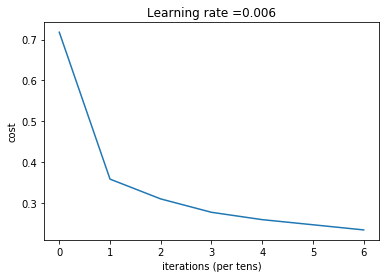

In [198]:
parameters = L_layer_model(training_set, Y_train, layers_dims, num_iterations = 70000, lambd = 0.7, print_cost = True)

In [199]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    A2, cache = L_model_forward(X, parameters)
    predictions = np.array([0 if i <= 0.5 else 1 for i in np.squeeze(A2)])
    
    return predictions

In [200]:
pred_train = predict(parameters,training_set)
print ('Accuracy: %d' % float((np.dot(Y_train,pred_train.T) + np.dot(1-Y_train,1-pred_train.T))/float(Y_train.size)*100) + '%')

Accuracy: 91%


In [201]:
pred_dev = predict(parameters, dev_set)
print ('Accuracy: %d' % float((np.dot(Y_dev,pred_dev.T) + np.dot(1-Y_dev,1-pred_dev.T))/float(Y_dev.size)*100) + '%')

Accuracy: 80%


In [202]:
test_array = test_df.as_matrix()
test_array = np.transpose(test_array)
Y_test_predictions = predict(parameters, test_array)

In [203]:
Y_test_predictions = Y_test_predictions.astype(int)
Y_test_df = pd.DataFrame(np.transpose(Y_test_predictions))

In [204]:
test_df_copy['Survived'] = Y_test_df

In [205]:
test_df_copy = test_df_copy.drop(['Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare', 'Cabin','Embarked'], axis=1)

In [206]:
test_df_copy.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [207]:
test_df_copy.to_csv('predictions.csv',index=False)